In [1]:
!pip3 install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 65.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# WLS license
params = {

}

# data path
file_path = ''

In [6]:
import pandas as pd
import numpy as np
import random
import math
import sys

pd.set_option('display.max_columns', None)

def dist(lat1, lng1, lat2, lng2):
    return np.abs(lat1 - lat2) + np.abs(lng1 - lng2)

def get_grid_ids(lng, lat, grid_size):
    grid_x = math.floor(lng / grid_size)
    grid_y = math.floor(lat / grid_size)
    return grid_x, grid_y

In [ ]:
import gurobipy as gp
from gurobipy import GRB

env = gp.Env(params=params)

def solve_model(w, c, R, beta, N_RESTAURANTS, N_CUSTOMERS, tau, LAMBDA, MU_P, V_MAX, K, verbose = 0):

    model = gp.Model(env = env)
    model.setParam("NonConvex", 2)
    model.setParam('MIPGap', 1e-2)

    # FLOW VARIABLES
    lam_f_rc = model.addMVar((N_RESTAURANTS, N_CUSTOMERS), lb = 0, ub = LAMBDA, vtype = GRB.CONTINUOUS, name = "lambda_f_rc")
    lam_p_rc = model.addMVar((N_RESTAURANTS, N_CUSTOMERS), lb = 0, ub = LAMBDA, vtype = GRB.CONTINUOUS, name = "lambda_p_rc")

    # the customer-restaurant flow is upper bounded by the total order rate from all restaurants to the customer
    lam_f_cr = model.addMVar((N_CUSTOMERS, N_RESTAURANTS), lb = 0, ub = np.tile(np.sum(LAMBDA, axis = 0), (N_RESTAURANTS, 1)).T, vtype = GRB.CONTINUOUS, name = "lambda_f_cr")
    lam_p_cr = model.addMVar((N_CUSTOMERS, N_RESTAURANTS), lb = 0, ub = np.tile(np.sum(LAMBDA, axis = 0), (N_RESTAURANTS, 1)).T, vtype = GRB.CONTINUOUS, name = "lambda_p_cr")

    mu_p_in  = model.addMVar(N_RESTAURANTS, lb = 0, ub = MU_P, vtype = GRB.CONTINUOUS, name = "mu_p_in")
    mu_p_out = model.addMVar(N_CUSTOMERS,   lb = 0, ub = MU_P, vtype = GRB.CONTINUOUS, name = "mu_p_out")

    # VALUES
    V_r = model.addMVar(N_RESTAURANTS, lb = R, ub = V_MAX, vtype = GRB.CONTINUOUS, name = "V_r")
    V_c = model.addMVar(N_CUSTOMERS,   lb = R, ub = V_MAX, vtype = GRB.CONTINUOUS, name = "V_c")
    V_bar = model.addVar(lb = R, ub = V_MAX, vtype = GRB.CONTINUOUS, name = "V_bar")

    # AUXILIARY VARIABLE FOR TOTAL COST OF PART-TIME
    T = model.addVar(lb = 0, ub = np.sum(2 * tau * LAMBDA * w), vtype = GRB.CONTINUOUS, name = "T")

    for i in range(N_RESTAURANTS):
        model.addConstr(V_bar >= V_r[i])
        model.addConstr(mu_p_in[i] * (V_bar - V_r[i]) == 0)
        model.addConstr(mu_p_in[i] + gp.quicksum(lam_p_cr[j, i] for j in range(N_CUSTOMERS)) == gp.quicksum(lam_p_rc[i, j] for j in range(N_CUSTOMERS)))
        model.addConstr(gp.quicksum(lam_f_cr[j, i] for j in range(N_CUSTOMERS)) == gp.quicksum(lam_f_rc[i, j] for j in range(N_CUSTOMERS)))

    for j in range(N_CUSTOMERS):
        model.addConstr(mu_p_out[j] * (V_c[j] - R) == 0)
        model.addConstr(gp.quicksum(lam_p_rc[i, j] for i in range(N_RESTAURANTS)) == gp.quicksum(lam_p_cr[j, i] for i in range(N_RESTAURANTS)) + mu_p_out[j])
        model.addConstr(gp.quicksum(lam_f_rc[i, j] for i in range(N_RESTAURANTS)) == gp.quicksum(lam_f_cr[j, i] for i in range(N_RESTAURANTS)))

    for j in range(N_CUSTOMERS):
      closest_restaurants = np.argsort(tau[:,j])[:K]
      for i in range(N_RESTAURANTS):

            model.addConstr(V_r[i] + c * tau[i, j] - beta ** tau[i, j] * V_c[j] >= 0)

            if LAMBDA[i,j] > 0:
              model.addConstr(lam_f_rc[i, j] + lam_p_rc[i, j] == LAMBDA[i, j])
            else:
              model.addConstr(lam_f_rc[i, j] == 0)
              model.addConstr(lam_p_rc[i, j] == 0)

            if i in closest_restaurants:
              model.addConstr(V_c[j] + c * tau[i, j] - beta ** tau[i, j] * V_r[i] >= 0)
              model.addConstr(lam_p_cr[j, i] * (V_c[j] + c * tau[i, j] - beta ** tau[i, j] * V_r[i]) == 0)
            else:
              model.addConstr(lam_p_cr[j, i] == 0)

    model.addConstr(MU_P >= gp.quicksum(mu_p_in[i] for i in range(N_RESTAURANTS)))
    model.addConstr(gp.quicksum(lam_p_rc[i, j] * (V_r[i] + c * tau[i, j] - beta ** tau[i, j] * V_c[j]) for i in range(N_RESTAURANTS) for j in range(N_CUSTOMERS)) == T)

    obj_func_1 = gp.quicksum(w * (lam_f_rc[i, j] + lam_f_cr[j, i]) * tau[i, j] for i in range(N_RESTAURANTS) for j in range(N_CUSTOMERS))
    obj_func_2 = T
    model.setObjective(obj_func_1 + obj_func_2, GRB.MINIMIZE)
    model.optimize()

    results = {
        "obj_val": model.ObjVal,
        "V_r": V_r.X,
        "V_c": V_c.X,
        "V_bar": V_bar.x,
        "mu_p_in": mu_p_in.X,
        "mu_p_out": mu_p_out.X,
        "lam_f_rc": lam_f_rc.X,
        "lam_p_rc": lam_p_rc.X,
        "lam_f_cr": lam_f_cr.X,
        "lam_p_cr": lam_p_cr.X,
        "T": T.x
    }

    return results

In [33]:
# read and process the whole dataset

all_waybill = pd.read_csv(file_path)

all_waybill['sender_lng'] /= 1e6
all_waybill['sender_lat'] /= 1e6
all_waybill['recipient_lng'] /= 1e6
all_waybill['recipient_lat'] /= 1e6
all_waybill['grab_lng'] /= 1e6
all_waybill['grab_lat'] /= 1e6

all_waybill['sender_lng'] = 6371 * 0.767 *  np.radians(all_waybill['sender_lng'])
all_waybill['sender_lat'] = 6371 * np.radians(all_waybill['sender_lat'])
all_waybill['recipient_lng'] = 6371 * 0.767 * np.radians(all_waybill['recipient_lng'])
all_waybill['recipient_lat'] = 6371 * np.radians(all_waybill['recipient_lat'])
all_waybill['grab_lng'] = 6371 * 0.767 * np.radians(all_waybill['grab_lng'])
all_waybill['grab_lat'] = 6371 * np.radians(all_waybill['grab_lat'])
all_waybill['delivery_distance'] = dist(all_waybill['recipient_lng'], all_waybill['recipient_lat'], all_waybill['sender_lng'], all_waybill['sender_lat'])

all_waybill['order_push_time_f'] = pd.to_datetime(all_waybill['order_push_time_f'])
all_waybill['dispatch_time_f'] = pd.to_datetime(all_waybill['dispatch_time_f'])
all_waybill['arrive_time_f'] = pd.to_datetime(all_waybill['arrive_time_f'])

all_waybill = all_waybill[~all_waybill['da_id'].isin([6,18])]
all_waybill = all_waybill.sort_values(["courier_id", "dispatch_time"]).reset_index(drop=True)

courier_trajectory = all_waybill[["courier_id", "order_id", "grab_time", "fetch_time", "arrive_time"]].drop_duplicates(subset = ["courier_id", "order_id"])
courier_trajectory.columns = ["courier_id", "order_id", "time_accepted", "time_pickup", "time_arrive"]
courier_trajectory = pd.wide_to_long(courier_trajectory, ["time"], i=["courier_id", "order_id"], j="action", sep = "_", suffix = "\\D+").reset_index()
courier_trajectory = courier_trajectory[courier_trajectory["time"] > 0]
courier_trajectory = courier_trajectory.merge(all_waybill[["courier_id", "order_id", "grab_lng", "grab_lat", "sender_lng", "sender_lat", "recipient_lng", "recipient_lat", "da_id", "estimate_arrived_time", "estimate_meal_prepare_time"]].drop_duplicates(), on = ["courier_id", "order_id"], how = "inner")
courier_trajectory["courier_lng"] = courier_trajectory.apply(lambda x: x["grab_lng"] if x["action"] == "accepted" else x["sender_lng"] if x["action"] == "pickup" else x["recipient_lng"], axis = 1)
courier_trajectory["courier_lat"] = courier_trajectory.apply(lambda x: x["grab_lat"] if x["action"] == "accepted" else x["sender_lat"] if x["action"] == "pickup" else x["recipient_lat"], axis = 1)
courier_trajectory = courier_trajectory[["courier_id", "order_id", "action", "time", "courier_lng", "courier_lat", "da_id", "estimate_arrived_time", "estimate_meal_prepare_time"]]
courier_trajectory = courier_trajectory.sort_values(["courier_id", "time"])
courier_trajectory["time"] = pd.to_datetime(courier_trajectory["time"], unit = "s", utc = True).dt.tz_convert('Asia/Shanghai')

courier_trajectory['time_diff'] = courier_trajectory['time'].diff()
courier_trajectory['courier_diff'] = courier_trajectory['courier_id'].diff()
courier_trajectory['lng_diff'] = courier_trajectory['courier_lng'].diff()
courier_trajectory['lat_diff'] = courier_trajectory['courier_lat'].diff()
courier_trajectory['distance'] = courier_trajectory['lng_diff'].abs() + courier_trajectory['lat_diff'].abs()
courier_trajectory['speed'] = (courier_trajectory['distance'] / courier_trajectory['time_diff'].dt.total_seconds()) * 3600

all_poi = all_waybill[['poi_id','da_id']].drop_duplicates().reset_index(drop=True)

part_time_da_ids = [0,1,2,4,5,9,12,13,22]
full_time_da_ids = [3,7,8,10,11,14,15,16,17,19,20,21]

common_poi_ids = set(all_poi[all_poi['da_id'].isin(part_time_da_ids)]['poi_id']).intersection(set(all_poi[all_poi['da_id'].isin(full_time_da_ids)]['poi_id']))
full_time_poi_ids = set(all_poi[all_poi['da_id'].isin(full_time_da_ids)]['poi_id']).difference(common_poi_ids)
part_time_poi_ids = set(all_poi[all_poi['da_id'].isin(part_time_da_ids)]['poi_id']).difference(common_poi_ids)

all_waybill['poi_type'] = all_waybill['poi_id'].apply(lambda x: 'common' if x in common_poi_ids else 'part_time' if x in part_time_poi_ids else 'full_time')

In [34]:
# select and process the peak-hour data

from sklearn.cluster import KMeans

start_time = pd.to_datetime("10:30").time()
end_time = pd.to_datetime("13:00").time()
total_hours = 2.5
total_days = 8

N_RESTAURANTS = 20
N_CUSTOMERS = 30

select_waybill = all_waybill[(all_waybill['order_push_time_f'].dt.time >= start_time) &
 (all_waybill['order_push_time_f'].dt.time <= end_time) &
                             (all_waybill['is_prebook'] == 0) &
                             (all_waybill['is_courier_grabbed'] == 1)].reset_index(drop = True)

select_restaurants = select_waybill[['sender_lng','sender_lat']].drop_duplicates()
select_customers = select_waybill[["recipient_lng", "recipient_lat"]].drop_duplicates()

clustering_restaurants = KMeans(n_clusters = N_RESTAURANTS, random_state = 0)
select_restaurants["sender_cluster"] = clustering_restaurants.fit_predict(np.array(select_restaurants[["sender_lng", "sender_lat"]]))

clustering_customers = KMeans(n_clusters = N_CUSTOMERS, random_state = 0)
select_customers["recipient_cluster"] = clustering_customers.fit_predict(np.array(select_customers[["recipient_lng", "recipient_lat"]]))

select_waybill = select_waybill.merge(select_restaurants, on = ["sender_lng", "sender_lat"]).merge(select_customers, on = ["recipient_lng", "recipient_lat"])

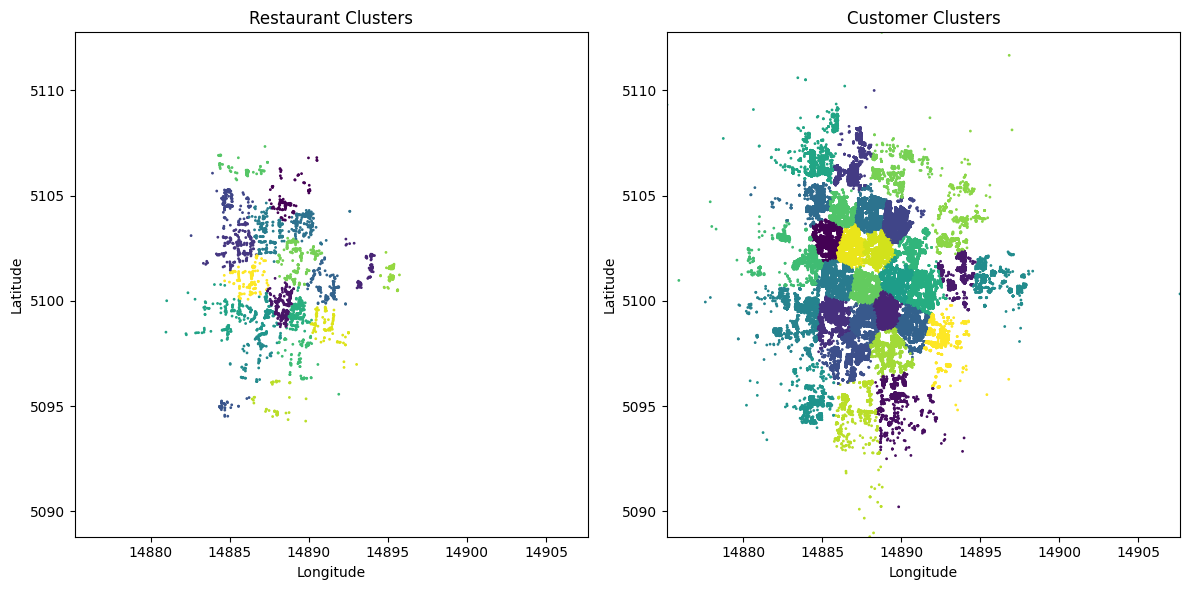

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(select_restaurants['sender_lng'], select_restaurants['sender_lat'], c=select_restaurants['sender_cluster'], s=1)
plt.title('Restaurant Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(min(min(select_customers['recipient_lng']), min(select_restaurants['sender_lng'])), max(max(select_customers['recipient_lng']), max(select_restaurants['sender_lng'])))
plt.ylim(min(min(select_customers['recipient_lat']), min(select_restaurants['sender_lat'])), max(max(select_customers['recipient_lat']), max(select_restaurants['sender_lat'])))

plt.subplot(1, 2, 2)
plt.scatter(select_customers['recipient_lng'], select_customers['recipient_lat'], c=select_customers['recipient_cluster'], s=1)
plt.title('Customer Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(min(min(select_customers['recipient_lng']), min(select_restaurants['sender_lng'])), max(max(select_customers['recipient_lng']), max(select_restaurants['sender_lng'])))
plt.ylim(min(min(select_customers['recipient_lat']), min(select_restaurants['sender_lat'])), max(max(select_customers['recipient_lat']), max(select_restaurants['sender_lat'])))

plt.tight_layout()
plt.show()

In [88]:
def calibrate_params(start_time, end_time, total_hours, total_days, clustering_restaurants, clustering_customers, arrival_rate_cut = 0.1):

  select_trajectory = courier_trajectory[(courier_trajectory['time'].dt.time >= start_time) &
    (courier_trajectory['time'].dt.time <= end_time) &
    (courier_trajectory['time_diff'] <= pd.Timedelta(hours = total_hours)) &
    (courier_trajectory['courier_diff'] == 0) &
    (courier_trajectory['action'] == 'arrive')]

  travel_speed = np.nanmean(select_trajectory['speed'])

  order_arrival = select_waybill.groupby(["sender_cluster", "recipient_cluster"]).size().reset_index(name='arrival_rate')
  order_arrival['arrival_rate'] /= (total_hours * total_days)

  LAMBDA = np.zeros((N_RESTAURANTS, N_CUSTOMERS))
  tau = np.zeros((N_RESTAURANTS, N_CUSTOMERS))

  for i in range(N_RESTAURANTS):
    for j in range(N_CUSTOMERS):
      tau[i,j] = dist(clustering_restaurants.cluster_centers_[i,0], clustering_restaurants.cluster_centers_[i,1], clustering_customers.cluster_centers_[j,0], clustering_customers.cluster_centers_[j,1]) / travel_speed
      if len(order_arrival[(order_arrival['sender_cluster'] == i)&(order_arrival['recipient_cluster'] == j)]) > 0:
        LAMBDA[i,j] = order_arrival[(order_arrival['sender_cluster'] == i)&(order_arrival['recipient_cluster'] == j)]['arrival_rate'].values[0]
      if LAMBDA[i,j] < arrival_rate_cut:
        LAMBDA[i,j] = 0

  MU_P = len(all_waybill[(all_waybill['order_push_time_f'].dt.time >= start_time) &
      (all_waybill['order_push_time_f'].dt.time <= end_time) &
      (all_waybill['is_prebook'] == 0) &
      (all_waybill['da_id'].isin(part_time_da_ids))][['dt','courier_id']].drop_duplicates()) / (total_hours * total_days)

  return tau, LAMBDA, MU_P

In [89]:
tau, LAMBDA, MU_P = calibrate_params(start_time, end_time, total_hours, total_days, clustering_restaurants, clustering_customers)

In [91]:
w = 33.6
c = 3
beta = 0.9

R = 26.43 + 26.43 * beta + 26.43/2 * beta**2

results = solve_model(w, c, R, beta, N_RESTAURANTS, N_CUSTOMERS, tau, LAMBDA, MU_P, V_MAX = max(R, w / np.log(1/beta)), K = 3)

Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
MIPGap  0.01
NonConvex  2

Academic license 2556960 - for non-commercial use only - registered to ju___@berkeley.edu
Optimize a model with 2119 rows, 2502 columns and 8000 nonzeros
Model fingerprint: 0x4ec06624
Model has 141 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-01, 1e+00]
  QMatrix range    [8e-01, 1e+00]
  QLMatrix range   [3e-02, 6e+01]
  Objective range  [3e-01, 6e+01]
  Bounds range     [1e-01, 1e+05]
  RHS range        [3e-02, 8e+02]
Presolve removed 907 rows and 906 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 1308 rows and 1308 columns
Presolve time: 0.02s
Presolved: 5138 rows, 2219 columns, 